# Final model

In [1]:
# Libraries
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# From project
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(parent_dir)

# Now you can import the preprocessor module
from ml_logic.data import DataCleaner

In [2]:
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)

/Users/virginiawenger/code/CodeWarriorM/hospital_readmission/ml_logic/data.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/Users/virginiawenger/code/CodeWarriorM/hospital_readmission/ml_logic/data.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/Users/virginiawenger/code/CodeWarriorM/hospital_readmission/ml_logic/data.py:111: FutureWarning: Downcasting behavior

In [3]:
processed_data.columns

Index(['readmitted', 'age', 'gender', 'race', 'level1_diag_1', 'level1_diag_2',
       'level1_diag_3', 'num_medications', 'num_lab_procedures',
       'num_procedures', 'numchange', 'nummed', 'A1Cresult', 'metformin',
       'pioglitazone', 'insulin', 'glipizide', 'glimepiride', 'diabetesMed',
       'comorbidity_count', 'number_diagnoses', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'total_visits',
       'time_in_hospital', 'change', 'age|comorbidity_count',
       'age|number_diagnoses', 'num_medications|num_lab_procedures',
       'num_medications|time_in_hospital', 'num_medications|num_procedures',
       'num_medications|number_diagnoses', 'number_diagnoses|time_in_hospital',
       'time_in_hospital|num_lab_procedures'],
      dtype='object')

In [4]:
# Numeric preprocessing pipeline (excluding 'readmitted')
numeric_columns = [col for col in processed_data.select_dtypes(include=['number']).columns if col != 'readmitted']
num_preproc = Pipeline([
    ('scaler', MinMaxScaler())
])


# Categorical preprocessing pipeline (excluding 'age')
categorical_columns = processed_data.select_dtypes(include=['object']).columns
cat_preproc = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, drop="if_binary", handle_unknown='ignore'))
])

# Combined preprocessing pipeline
preproc = ColumnTransformer([
    ('num_transf', num_preproc, numeric_columns),
    ('cat_transf', cat_preproc, categorical_columns)
], verbose_feature_names_out=False).set_output(transform='pandas')


# Create a pipeline with SMOTE and preprocessing
pipe_preproc = ImbPipeline([
    ('preprocessor', preproc),
])
pipe_preproc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transf',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'level1_diag_1',
                                                   'level1_diag_2',
                                                   'level1_diag_3',
                                                   'num_medications',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'numchange', 'nummed',
                                                   'metformin', 'pioglitazone',
                                                   'insulin', 'glipizide',
                                                   'glimepiride',
                                                   'comorbidity_count',
                                                   'number_diagn...
                                                   'number_diagnoses|time_in_hospital',
                                                   'time_in_hospital|num_lab_procedures']),
                                                 ('cat_transf',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'race', 'A1Cresult', 'diabetesMed', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id'],
      dtype='object'))],
                                   verbose_feature_names_out=False))])

In [5]:
# Apply the preprocessing pipeline to data
# Separate features and target
X = processed_data.drop('readmitted', axis=1)
y = processed_data['readmitted']

In [6]:

# Split the data into training + validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Further split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True)  # 0.25 * 0.8 = 0.2

In [7]:
# Fit and transform the training data with preprocessing pipeline
X_train_preprocessed = pipe_preproc.fit_transform(X_train)
X_val_preprocessed = pipe_preproc.transform(X_val)
X_test_preprocessed = pipe_preproc.transform(X_test)

In [8]:
# Save the preprocessing pipeline as a pickle file
with open('../preprocessor/preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(pipe_preproc, file)

In [9]:
# # Apply SMOTE to the preprocessed training data
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

In [10]:

minority_count = y_train.value_counts()[1]  # Count of class 1
majority_count = y_train.value_counts()[0]  # Count of class 0

# Perform undersampling
undersample_ratio = {0: minority_count, 1: minority_count}  # Undersample majority class to match minority class
rus = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=42)

X_train_smote, y_train_smote = rus.fit_resample(X_train_preprocessed, y_train)

# Check the class distribution after undersampling
pd.Series(y_train_smote).value_counts()


readmitted
0    3671
1    3671
Name: count, dtype: int64

In [11]:
print(f"Original training set distribution: {Counter(y_train)}")
print(f"Resampled training set distribution: {Counter(y_train_smote)}")


Original training set distribution: Counter({0: 36877, 1: 3671})
Resampled training set distribution: Counter({0: 3671, 1: 3671})


In [12]:
rm = RandomForestClassifier(n_estimators=10, max_depth=25, criterion="gini", min_samples_split=10, class_weight={0: 1, 1: 10})

rm.fit(X_train_smote, y_train_smote)
best_model = rm

In [13]:
y_val_pred_gb = rm.predict(X_val_preprocessed)
print("Random Forest Validation Performance")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_gb):.4f}")
print(f"Validation Precision: {precision_score(y_val, y_val_pred_gb):.4f}")
print(f"Validation Recall: {recall_score(y_val, y_val_pred_gb):.4f}")
gb_score = accuracy_score(y_val, y_val_pred_gb)

Random Forest Validation Performance
Validation Accuracy: 0.2862
Validation Precision: 0.0972
Validation Recall: 0.8399


In [14]:
y_test_pred = best_model.predict(X_test_preprocessed)
print("Best Model Test Performance")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")

Best Model Test Performance
Test Accuracy: 0.2873
Test Precision: 0.0993
Test Recall: 0.8339


In [15]:

# Calculate permutation importance
perm_importance = permutation_importance(rm, X_train_smote, y_train_smote, n_repeats=10, random_state=42)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train_smote.columns,
                                        perm_importance.importances_mean)).T)
importance_df.columns=['feature','score decrease']
# Show the important features
importance_df.sort_values(by="score decrease", ascending = False).head(20)

,feature,score decrease
41,discharge_disposition_id_1,0.061305
20,age|number_diagnoses,0.04082
16,total_visits,0.039826
42,discharge_disposition_id_2,0.0231
5,num_lab_procedures,0.022133
1,level1_diag_1,0.022119
2,level1_diag_2,0.020648
11,insulin,0.01994
19,age|comorbidity_count,0.018646
14,comorbidity_count,0.016984


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53

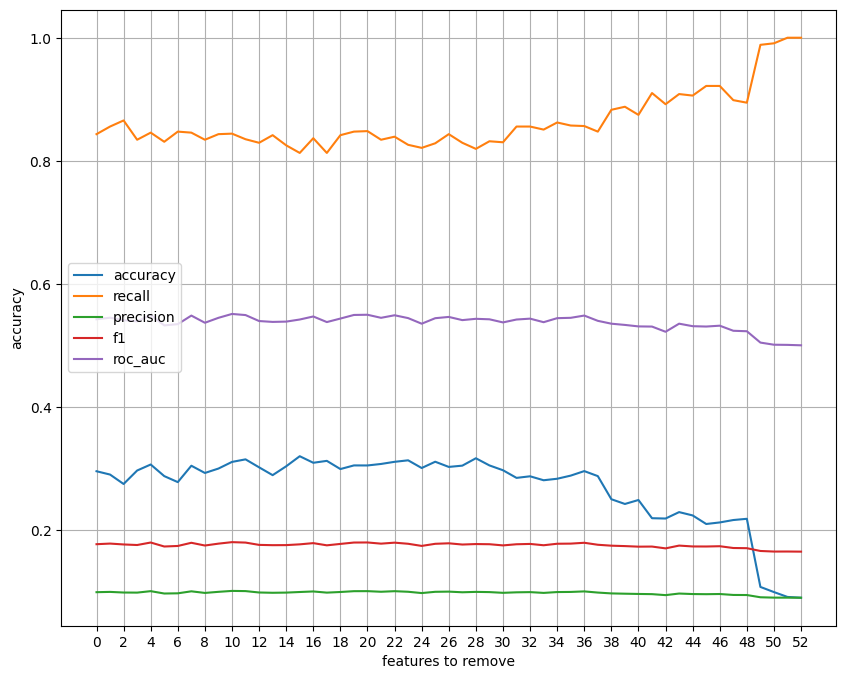

In [16]:
metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
scores = {metric: [] for metric in metrics}
n_features = X_train_smote.shape[1]

for cols_to_drop in range(1, n_features):
    print(f' {cols_to_drop}', end='')

    keep_col = importance_df.sort_values(by="score decrease", ascending = False).feature[:-cols_to_drop].to_list()
    X_bal_reduced = X_train_smote[keep_col]
    X_val_reduced = X_val_preprocessed[keep_col]

    model = best_model
    model.fit(X_bal_reduced, y_train_smote)

    y_val_pred = model.predict(X_val_reduced)

    scores['accuracy'] = scores['accuracy'] + [accuracy_score(y_val, y_val_pred)]
    scores['recall'] = scores['recall'] + [recall_score(y_val, y_val_pred)]
    scores['precision'] = scores['precision'] + [precision_score(y_val, y_val_pred)]
    scores['f1'] = scores['f1'] + [f1_score(y_val, y_val_pred)]
    scores['roc_auc'] = scores['roc_auc'] + [roc_auc_score(y_val, y_val_pred)]

scores_df = pd.DataFrame(scores)

plt.figure(figsize=(10, 8))
for metric in metrics:
    sns.lineplot(scores_df[metric], label=metric)
plt.xlabel('features to remove')
plt.xticks([*range(0, n_features, 2)])
plt.grid(visible=True, which='both')
plt.legend(loc='center left')

In [17]:
# Find the row with the maximum recall and corresponding accuracy
best_recall_idx = scores_df['recall'].idxmax()
best_accuracy_for_recall = scores_df.loc[best_recall_idx, 'accuracy']

# Find the row with the maximum accuracy and corresponding recall
best_accuracy_idx = scores_df['accuracy'].idxmax()
best_recall_for_accuracy = scores_df.loc[best_accuracy_idx, 'recall']

# Determine the best combination based on a balance between recall and accuracy
if best_recall_for_accuracy > best_accuracy_for_recall:
    best_combination = scores_df.loc[best_accuracy_idx]
else:
    best_combination = scores_df.loc[best_recall_idx]

# Print the details of the best combination
print(f"Best combination found at {best_combination.name} features removed:")
print(f"Recall: {best_combination['recall']:.4f}")
print(f"Accuracy: {best_combination['accuracy']:.4f}")
print(f"Precision: {best_combination['precision']:.4f}")
print(f"F1 Score: {best_combination['f1']:.4f}")
print(f"ROC AUC: {best_combination['roc_auc']:.4f}")


Best combination found at 15 features removed:
Recall: 0.8127
Accuracy: 0.3197
Precision: 0.0990
F1 Score: 0.1764
ROC AUC: 0.5419


In [18]:
n_features_to_remove = 37
keep_col = importance_df.sort_values(by="score decrease", ascending = False).feature[:-n_features_to_remove].to_list()

X_bal_reduced = X_train_smote[keep_col]
X_val_reduced = X_val_preprocessed[keep_col]
X_test_reduced = X_test_preprocessed[keep_col]

model = best_model
model.fit(X_bal_reduced, y_train_smote)


y_val_pred = model.predict(X_val_reduced)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Validation Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"Validation Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Validation F1: {f1_score(y_val, y_val_pred):.4f}")
print(f"Validation ROC-AUC: {roc_auc_score(y_val, y_val_pred):.4f}")

print("----")
y_test_pred = model.predict(X_test_reduced)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test F1: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_pred):.4f}")


Validation Accuracy: 0.2875
Validation Recall: 0.8556
Validation Precision: 0.0988
Validation F1: 0.1772
Validation ROC-AUC: 0.5436
----
Test Accuracy: 0.2946
Test Recall: 0.8451
Test Precision: 0.1013
Test F1: 0.1809
Test ROC-AUC: 0.5419


In [19]:
keep_col

['discharge_disposition_id_1',
 'age|number_diagnoses',
 'total_visits',
 'discharge_disposition_id_2',
 'num_lab_procedures',
 'level1_diag_1',
 'level1_diag_2',
 'insulin',
 'age|comorbidity_count',
 'comorbidity_count',
 'level1_diag_3',
 'diabetesMed_Yes',
 'num_medications|num_lab_procedures',
 'nummed',
 'age',
 'number_diagnoses|time_in_hospital',
 'num_medications|time_in_hospital']

In [20]:
# Load the data and preprocess
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)

# Apply the preprocessing pipeline to data
# Separate features and target
X = processed_data.drop('readmitted', axis=1)
y = processed_data['readmitted']

# Split the data into training + validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Further split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True)  # 0.25 * 0.8 = 0.2

# Preproc pipeline
# Numeric preprocessing pipeline (excluding 'readmitted')
numeric_columns = [col for col in processed_data.select_dtypes(include=['number']).columns if col != 'readmitted']
num_preproc = Pipeline([
    ('scaler', MinMaxScaler())
])


# Categorical preprocessing pipeline (excluding 'age')
categorical_columns = processed_data.select_dtypes(include=['object']).columns
cat_preproc = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, drop="if_binary", handle_unknown='ignore'))
])

# Combined preprocessing pipeline
preproc = ColumnTransformer([
    ('num_transf', num_preproc, numeric_columns),
    ('cat_transf', cat_preproc, categorical_columns)
], verbose_feature_names_out=False).set_output(transform='pandas')


# Create a pipeline with SMOTE and preprocessing
pipe_preproc = ImbPipeline([
    ('preprocessor', preproc),
])
pipe_preproc

# Fit and transform the training data with preprocessing pipeline
X_train_preprocessed = pipe_preproc.fit_transform(X_train)
X_val_preprocessed = pipe_preproc.transform(X_val)
X_test_preprocessed = pipe_preproc.transform(X_test)

# Only keep relevant features
X_train_preprocessed = X_train_preprocessed[keep_col]
X_val_preprocessed = X_val_preprocessed[keep_col]
X_test_preprocessed = X_test_preprocessed[keep_col]

# Balance
minority_count = y_train.value_counts()[1]  # Count of class 1
majority_count = y_train.value_counts()[0]  # Count of class 0

# Perform undersampling
undersample_ratio = {0: minority_count, 1: minority_count}  # Undersample majority class to match minority class
rus = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=42)

X_train_smote, y_train_smote = rus.fit_resample(X_train_preprocessed, y_train)

# Check the class distribution after undersampling
pd.Series(y_train_smote).value_counts()


best_model = RandomForestClassifier(n_estimators=10, max_depth=25, criterion="gini", min_samples_split=10, class_weight={0: 1, 1: 10})
rm.fit(X_train_smote, y_train_smote)
best_model = rm
y_test_pred = model.predict(X_test_reduced)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test F1: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_pred):.4f}")

pipe = Pipeline([
    ('preprocessor', pipe_preproc),  # Use pipe_preproc without parentheses
    ('Random Forest', best_model)
])

# Check the pipeline
pipe


/Users/virginiawenger/code/CodeWarriorM/hospital_readmission/ml_logic/data.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/Users/virginiawenger/code/CodeWarriorM/hospital_readmission/ml_logic/data.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/Users/virginiawenger/code/CodeWarriorM/hospital_readmission/ml_logic/data.py:111: FutureWarning: Downcasting behavior

Test Accuracy: 0.2981
Test Recall: 0.8395
Test Precision: 0.1012
Test F1: 0.1807
Test ROC-AUC: 0.5413


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num_transf',
                                                                   Pipeline(steps=[('scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age',
                                                                    'level1_diag_1',
                                                                    'level1_diag_2',
                                                                    'level1_diag_3',
                                                                    'num_medications',
                                                                    'num_lab_procedures',
                                                                    'num_procedures',
                                                                    'numchange',
                                                                    'nummed',
                                                                    'metformin',
                                                                    'pioglitazone',
                                                                    'insulin',
                                                                    'glipizide',
                                                                    'glimepiride',
                                                                    '...
                                                                                    OneHotEncoder(drop='if_binary',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   Index(['gender', 'race', 'A1Cresult', 'diabetesMed', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id'],
      dtype='object'))],
                                                    verbose_feature_names_out=False))])),
                ('Random Forest',
                 RandomForestClassifier(class_weight={0: 1, 1: 10},
                                        max_depth=25, min_samples_split=10,
                                        n_estimators=10))])